# EDA: Swire Coca - Cola
## Griffin Brown
9/4/24

This file serves as my personal EDA for the IWC Work Orders.

## Data Loading

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.cloud import storage
import os
from io import StringIO

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
file_name = 'IWC_Work_Orders_Extract.csv'

if os.path.exists(file_name):
    # Load the file from the local file system
    df = pd.read_csv(file_name, low_memory=False)
    print("File loaded from local storage.")
else:
    # File not found locally, fetch from Google Cloud Storage
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "swire-capstone-2024-0b05c28274b1.json"

    STORAGE_BUCKET = 'swire-provided-data'

    # Initialize the Google Cloud Storage client
    storage_client = storage.Client()
    bucket = storage_client.bucket(STORAGE_BUCKET)

    # Path to the file in the bucket
    file_path_in_bucket = 'IWC_Work_Orders_Extract.csv'

    # Get the blob (file) from the bucket
    blob = bucket.blob(file_path_in_bucket)

    # Download the file content as a string
    csv_data = blob.download_as_string()

    # Use StringIO to convert the string data to a file-like object for pandas
    df = pd.read_csv(StringIO(csv_data.decode('utf-8')), low_memory=False)
    print("File loaded from Google Cloud Storage.")

File loaded from local storage.


In [6]:
df.shape

(1427264, 25)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

In [186]:
total_rows = len(df)

sparsity = (total_rows - df.isnull().sum()) / total_rows * 100

sparsity_df = pd.DataFrame({'non_na_percentage': sparsity})

sparsity_df

,non_na_percentage
ORDER_ID,100.000000
PLANT_ID,100.000000
PRODUCTION_LOCATION,100.000000
EXECUTION_START_DATE,100.000000
EXECUTION_FINISH_DATE,100.000000
ACTUAL_START_TIME,100.000000
ACTUAL_FINISH_TIME,100.000000
ACTUAL_WORK_IN_MINUTES,100.000000
MAINTENANCE_PLAN,10.691365
MAINTENANCE_ITEM,10.691365


In [193]:
total_size = df.size

total_na = df.isna().sum().sum()

print(f'Total fill of dataframe: {round(((total_size - total_na) / total_size) * 100, 2)}%')

Total fill of dataframe: 55.0%


Lots of sparsity in this. I wonder if I can map equipment descriptions and category descriptions for blanks based on the equipment_id.

## Data Cleaning

### Mapping
Maybe there's room to enrich rows by mapping by equipment_id.

In [9]:
print(df['EQUIPMENT_DESC'].isna().sum())

1347817


I'm going to create a function that can check if there is a presence of a null value and a not null value, which would tell me that I can fill in nulls by mapping the equipment_id back to the column in question.

In [10]:
# creating two columns indicating presence of null and non-null values
def null_maps_check(column):
    equipment_desc_status = df.groupby('EQUIPMENT_ID').agg(
        has_null=(column, lambda x: x.isnull().any()),
        has_non_null=(column, lambda x: x.notnull().any())
    )

    # Filter where both null and non-null equipment descriptions exist
    equipment_with_both_null_and_non_null = equipment_desc_status[(equipment_desc_status['has_null']) & (equipment_desc_status['has_non_null'])]

    # Display the result
    return(equipment_with_both_null_and_non_null)


In [11]:
null_maps_check('EQUIPMENT_DESC').sum()

has_null        0
has_non_null    0
dtype: int64

In [12]:
null_maps_check('EQUIP_CAT_DESC').sum()

has_null        0
has_non_null    0
dtype: int64

In [13]:
null_maps_check('MAINTENANCE_ITEM').sum()

has_null        1231
has_non_null    1231
dtype: int64

In [14]:
null_maps_check('MAINTENANCE_PLAN').sum()

has_null        1231
has_non_null    1231
dtype: int64

1231 rows doesn't seem worth while to try to map back. I wonder if equipment_id was later featured in the software and therefore the dataset, which tells me it might just be useful to only use information after this point.

In [15]:
df_non_na_equipment = df[df['EQUIPMENT_ID'].notna()]

df_non_na_equipment['EXECUTION_START_DATE'].min()

'2017-02-27'

It seems like it's been in there for a while.

### Dates

In [16]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

### Times
I struggled to get the time stamps to correctly format.

In [17]:
df['ACTUAL_START_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_START_TIME'], errors='coerce')
df['ACTUAL_FINISH_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_FINISH_TIME'], errors='coerce')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   ORDER_ID                         1427264 non-null  int64         
 1   PLANT_ID                         1427264 non-null  object        
 2   PRODUCTION_LOCATION              1427264 non-null  object        
 3   EXECUTION_START_DATE             1427264 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            1427264 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                1427264 non-null  datetime64[ns]
 6   ACTUAL_FINISH_TIME               1427264 non-null  datetime64[ns]
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64       
 8   MAINTENANCE_PLAN                 152594 non-null   object        
 9   MAINTENANCE_ITEM                 152594 non-null   float64       
 10  MAINTENANCE_ACTIVITY_TYPE     

Since the data is big, I figured I would break down the start dates to other forms for possible easier visualization.

In [18]:
df['START_YEAR_MONTH'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.strftime('%Y-%m')
df['YEAR'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.year

In [19]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,START_YEAR_MONTH,YEAR
0,705642457,G812,ROMA,2024-05-04,2024-05-12,1900-01-01 06:00:00,1900-01-01 23:04:08,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2024-05,2024
1,704191697,G812,ROMA,2022-09-13,2022-09-13,1900-01-01 06:00:00,1900-01-01 17:17:24,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-09,2022
2,704466547,G812,ROMA,2022-12-21,2022-12-21,1900-01-01 07:00:00,1900-01-01 07:00:00,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-12,2022
3,703834477,G812,ROMA,2022-07-04,2022-07-04,1900-01-01 06:00:00,1900-01-01 06:00:00,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-07,2022
4,704661125,G291,MONZA,2023-03-15,2023-03-15,1900-01-01 07:00:00,1900-01-01 07:00:00,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,NaT,2023-03,2023


### Basic Stats

In [20]:
df.nunique()

ORDER_ID                           1427244
PLANT_ID                                 6
PRODUCTION_LOCATION                      6
EXECUTION_START_DATE                  2956
EXECUTION_FINISH_DATE                 2956
ACTUAL_START_TIME                    65927
ACTUAL_FINISH_TIME                   61388
ACTUAL_WORK_IN_MINUTES                4801
MAINTENANCE_PLAN                      3308
MAINTENANCE_ITEM                      4021
MAINTENANCE_ACTIVITY_TYPE                2
ORDER_DESCRIPTION                   118925
MAINTENANCE_TYPE_DESCRIPTION             5
FUNCTIONAL_LOC                         667
FUNCTIONAL_AREA_NODE_1_MODIFIED          7
FUNCTIONAL_AREA_NODE_2_MODIFIED         67
FUNCTIONAL_AREA_NODE_3_MODIFIED        141
FUNCTIONAL_AREA_NODE_4_MODIFIED         86
FUNCTIONAL_AREA_NODE_5_MODIFIED         36
EQUIPMENT_ID                          2956
EQUIPMENT_DESC                         807
EQUIP_CAT_DESC                           4
EQUIP_START_UP_DATE                     92
EQUIP_VALID

In [21]:
count_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].count()

count_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned       150387
Unplanned    1276877
Name: ACTUAL_WORK_IN_MINUTES, dtype: int64

Unplanned maintenance seems to dominate the work orders.

In [22]:
df.groupby('MAINTENANCE_ACTIVITY_TYPE')['EQUIPMENT_ID'].apply(lambda x: x.isnull().sum())


MAINTENANCE_ACTIVITY_TYPE
Planned            0
Unplanned    1135469
Name: EQUIPMENT_ID, dtype: int64

In [23]:
avg_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].mean()

avg_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned      48.034311
Unplanned    93.410893
Name: ACTUAL_WORK_IN_MINUTES, dtype: float64

Planned maintenance from a superficial level seems to last less time.

## EDA

### Categorical Variables

In [83]:
def categorical_plot(column):
    category_counts = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(14,8))
    category_counts.plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [25]:
cat_list = ['PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIP_CAT_DESC']

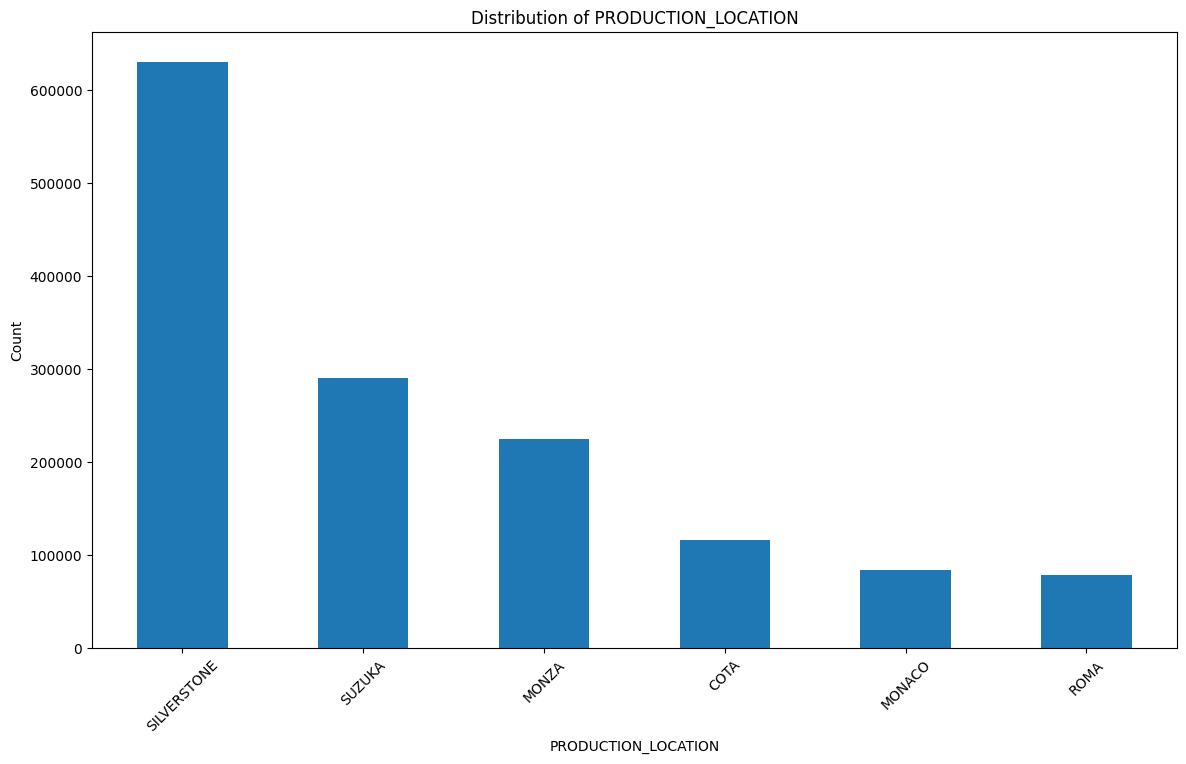

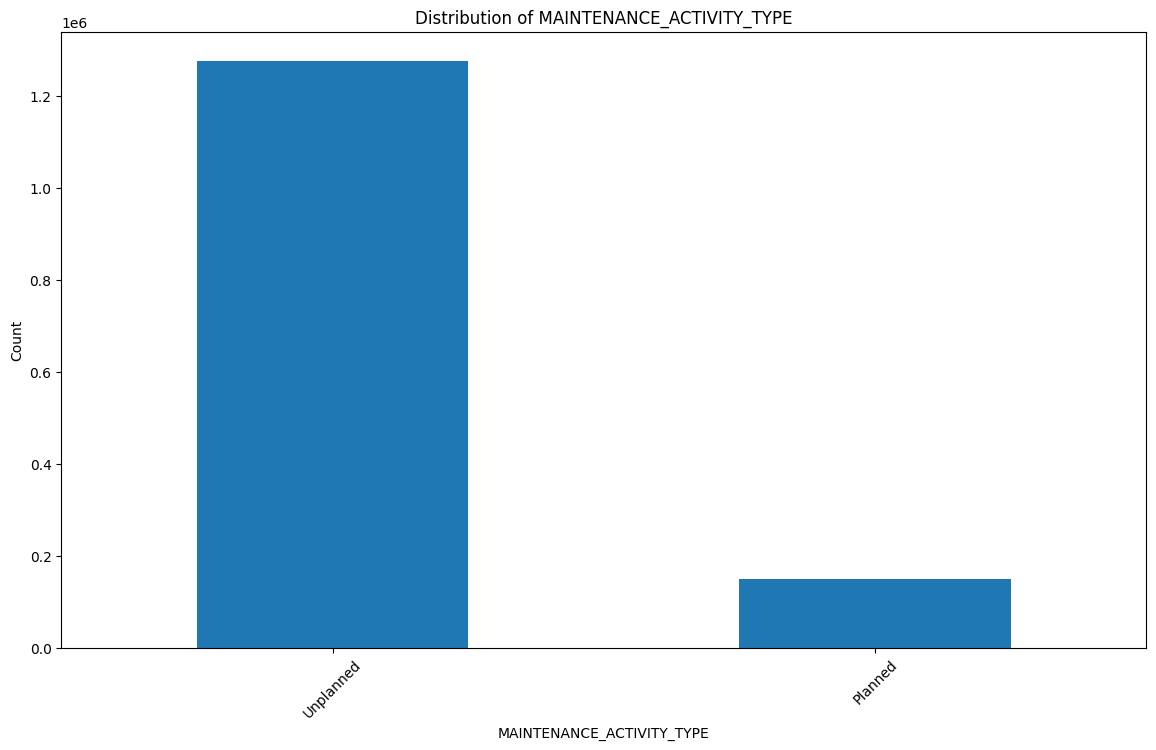

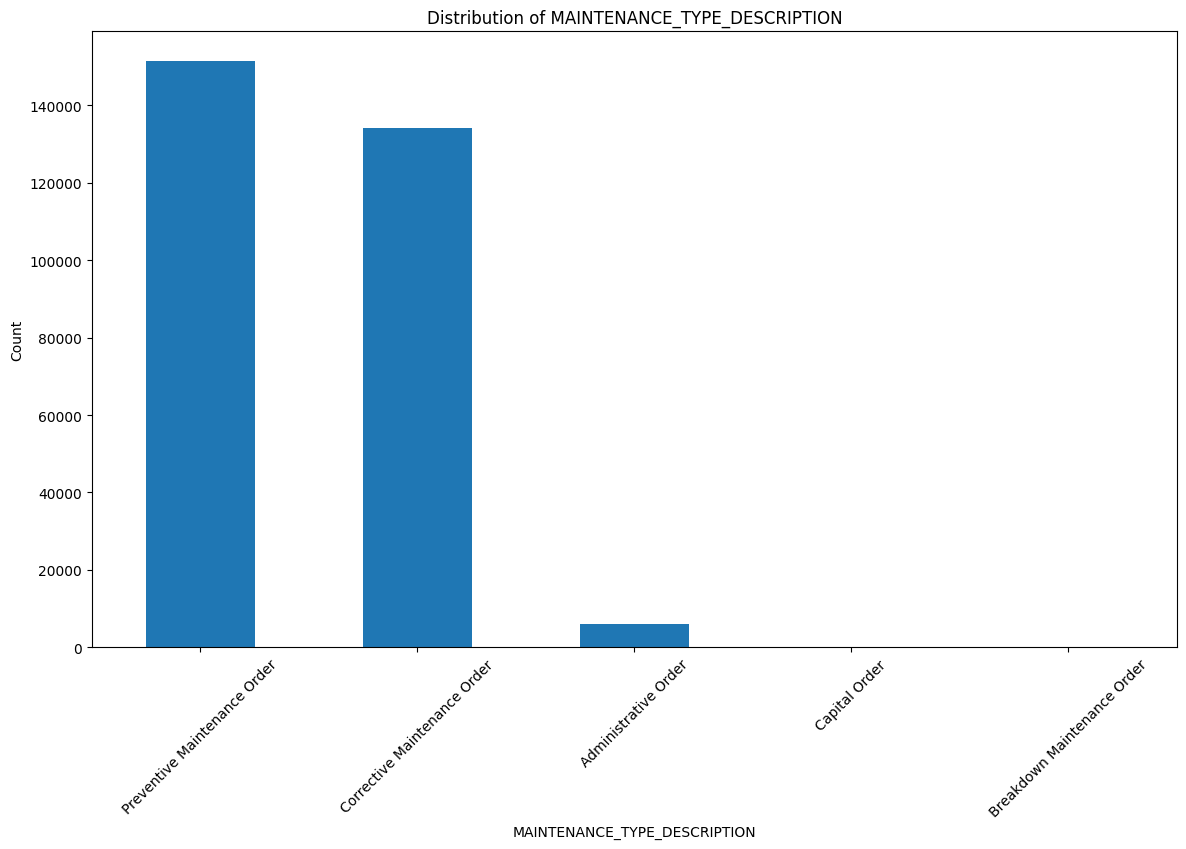

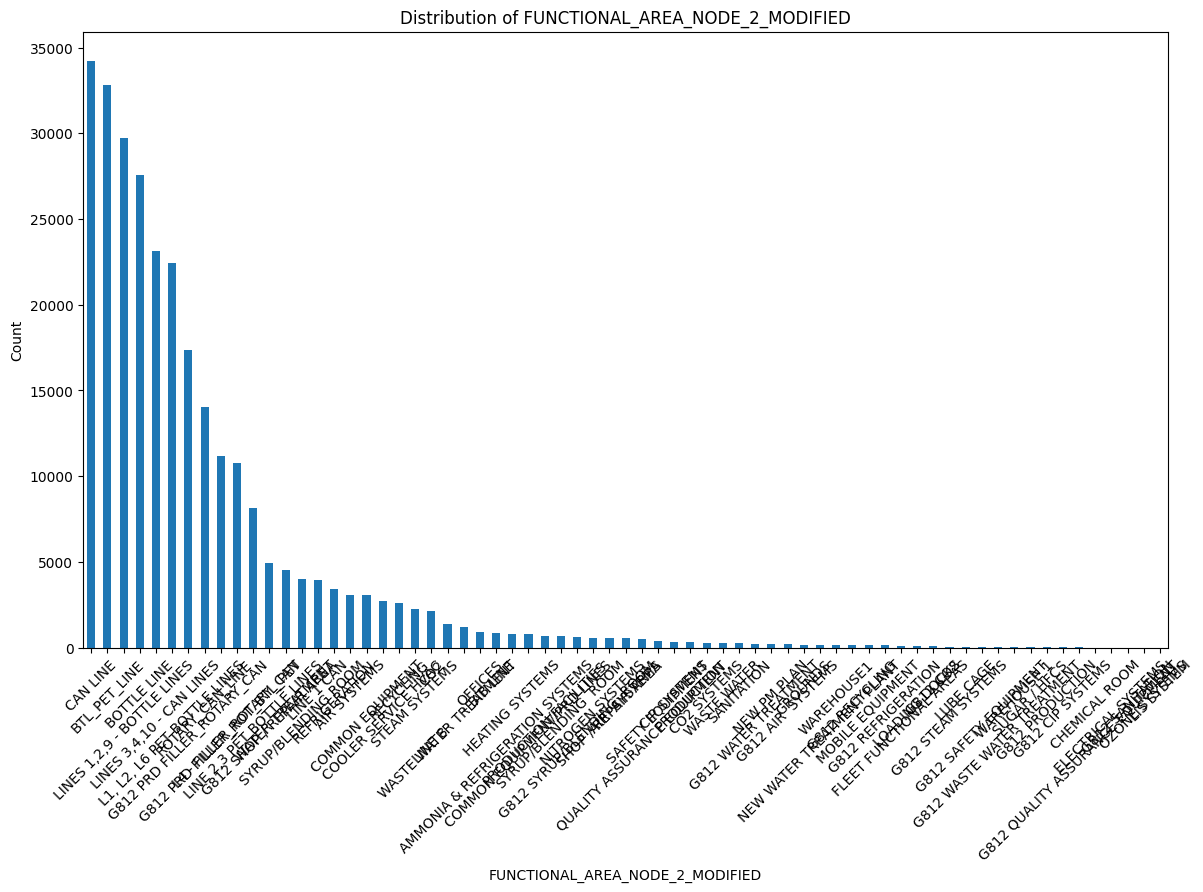

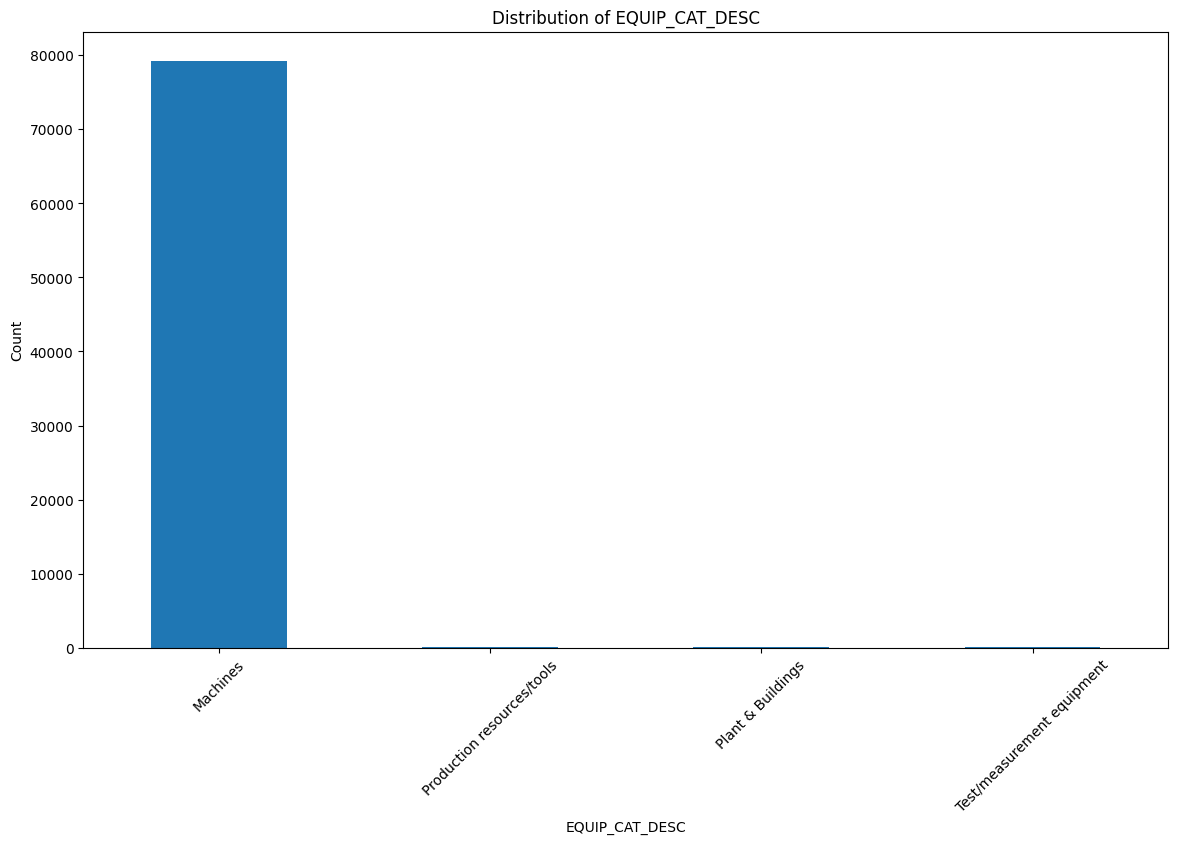

In [84]:
for cat in cat_list:
    categorical_plot(cat)

### Numeric Variables

In [96]:
def numeric_plot(column):
    plt.figure(figsize=(10,6))
    plt.hist(df[column], bins=2500, edgecolor='black')
    plt.title('Distribution of Actual Work Time (in Minutes)')
    plt.xlabel('Actual Work Time in Minutes')
    plt.ylabel('Frequency')
    plt.show()

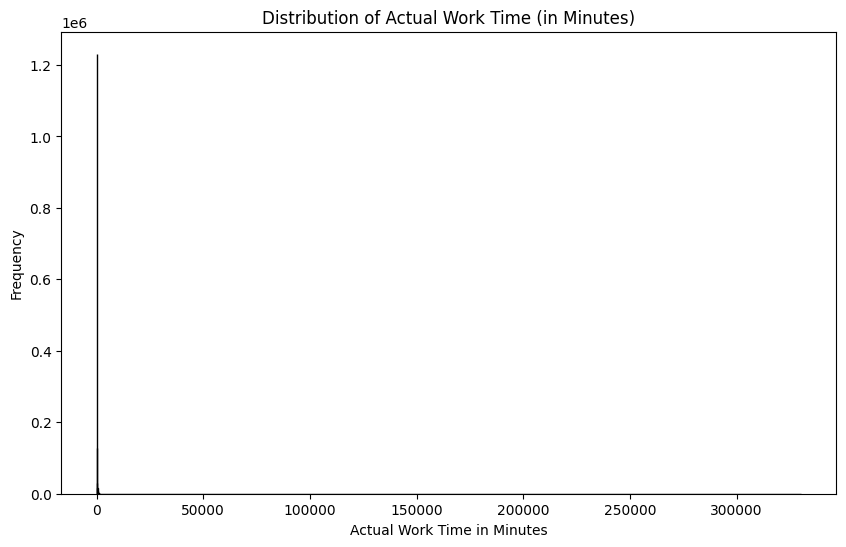

In [97]:
numeric_plot('ACTUAL_WORK_IN_MINUTES')

There must be an outlier in here. I'll attempt to get rid of it.

In [102]:
df['ACTUAL_WORK_IN_MINUTES'].sort_values(ascending=False).head()

172078    330184.8
739918    315747.6
481102    307918.8
122894    294321.0
630977    228133.2
Name: ACTUAL_WORK_IN_MINUTES, dtype: float64

In [103]:
# convert highest value to days
330184.8/60/24

229.295

Is this reasonable? Maybe I should take out 0s and see if that changes something.

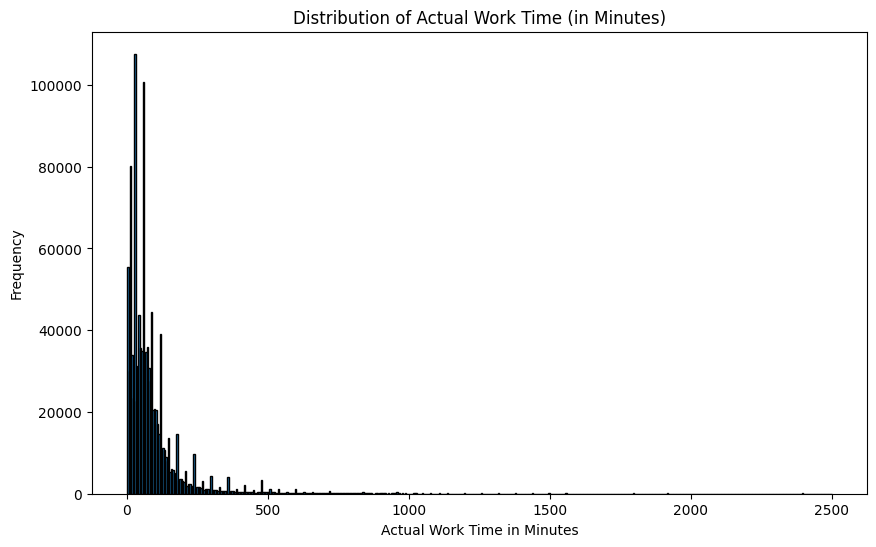

In [115]:
filtered = df['ACTUAL_WORK_IN_MINUTES'][(df['ACTUAL_WORK_IN_MINUTES'] > 0) & (df['ACTUAL_WORK_IN_MINUTES'] <= 2500)]
plt.figure(figsize=(10,6))
plt.hist(filtered, bins=500, edgecolor='black')
plt.title('Distribution of Actual Work Time (in Minutes)')
plt.xlabel('Actual Work Time in Minutes')
plt.ylabel('Frequency')
plt.show()

A little easier to tell, but the fast majority of jobs that are occuring are under 500 minutes.

### Time
Time is going to be a big variable in this dataset. It marks when things are being maintained, and for how long. Time is ultimately the metric we want to focus on.

In [27]:
min_date = df['EXECUTION_START_DATE'].min()
max_date = df['EXECUTION_FINISH_DATE'].max()

time_diff = max_date - min_date

time_diff_years = round((time_diff.days / 365.25), 2)

print(f'Timeframe:', time_diff_years, 'years')

Timeframe: 11.03 years


The data stretches over 11 years.

<Figure size 1000x600 with 0 Axes>

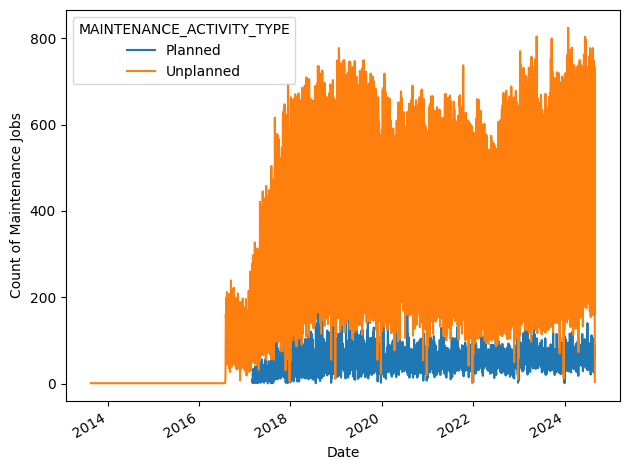

In [28]:
jobs_by_day_type = df.groupby(['EXECUTION_START_DATE','MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10,6))
jobs_by_day_type.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


A bit too busy to look at by date.

<Figure size 1000x600 with 0 Axes>

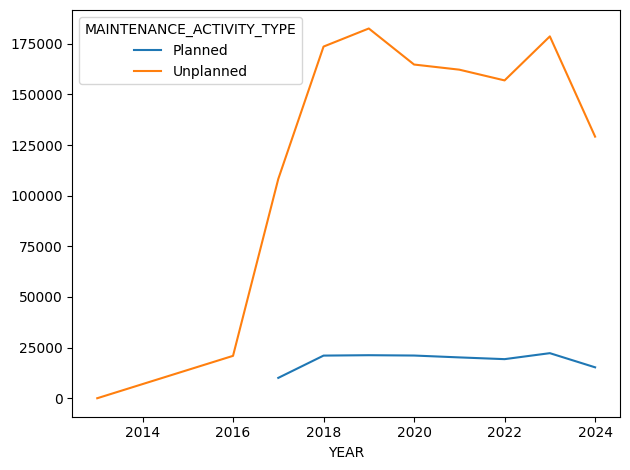

In [29]:
count_by_year = df.groupby(['YEAR', 'MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10, 6))
count_by_year.plot(kind='line')
plt.tight_layout()
plt.show()

Something tells me that only data after the 2017 mark seems to be at a level that is worth looking at. Perhaps the company didn't roll this system out to other plants until after 2016. It's also worth noting that "planned" maintenance orders didn't start until about 2017 and from 2018 on, it was fairly consistent.

In [30]:
df_2016 = df[df['YEAR'] == 2016]

df_2016.groupby('PRODUCTION_LOCATION').size()

PRODUCTION_LOCATION
SILVERSTONE    20925
dtype: int64

Well that's interesting, maybe to be safe I'll check 2017 and 2018.

In [31]:
df_2017 = df[df['YEAR'] == 2017]
print(df_2017.groupby('PRODUCTION_LOCATION').size())

df_2018 = df[df['YEAR'] == 2018]
print(df_2018.groupby('PRODUCTION_LOCATION').size())

PRODUCTION_LOCATION
COTA            3285
MONZA          23351
ROMA            3678
SILVERSTONE    59551
SUZUKA         28440
dtype: int64
PRODUCTION_LOCATION
COTA           13438
MONACO         12404
MONZA          30902
ROMA           10840
SILVERSTONE    80447
SUZUKA         46610
dtype: int64


COTA and ROMA seem to have way less in 2017, which may be due to late adoption of the software. Perhaps down the road, it will be worth it to slice this data for more accurate distributions.

In [32]:
df_2018 = df[df['YEAR'] >= 2018]

Let's do a check by hour to see what the distribution looks like.

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_92249/3271528084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['hour_start'] = df_2018['ACTUAL_START_TIME'].dt.hour


<Figure size 1000x600 with 0 Axes>

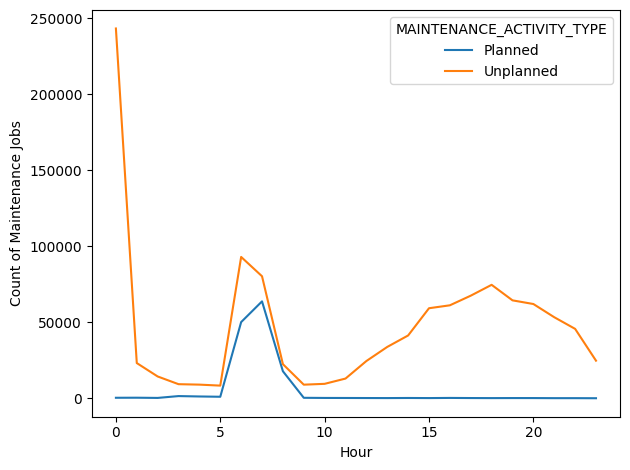

In [33]:
df_2018['hour_start'] = df_2018['ACTUAL_START_TIME'].dt.hour
count_by_hour_type = df_2018.groupby(['hour_start','MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10,6))
count_by_hour_type.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

This doesn't seem to be much help, knowing that Swire admitted that lots of jobs did not have a proper timestamp, which accounts for the spike at midnight. Planned maintenance seems to be done at a consistent time of day.

### Production Location
It will be critical to split any stats up by each location, since we don't know much about each one. Each one could be functionally different, or have a different work culture that effects the number of work orders. 

In [34]:
sum_minutes_by_location = df_2018.groupby('PRODUCTION_LOCATION').agg(
    count=('PRODUCTION_LOCATION', 'size'),
    total_mins = ('ACTUAL_WORK_IN_MINUTES', 'sum')
)
sum_minutes_by_location['average_mins_per_order'] = sum_minutes_by_location['total_mins']/sum_minutes_by_location['count']

sum_minutes_by_location


,count,total_mins,average_mins_per_order
PRODUCTION_LOCATION,,,
COTA,113018,6908284.8,61.125527
MONACO,84694,5567999.4,65.742548
MONZA,201928,19077631.8,94.477397
ROMA,75432,3857403.6,51.137496
SILVERSTONE,550426,51145556.3,92.919950
SUZUKA,262535,26435137.7,100.691861


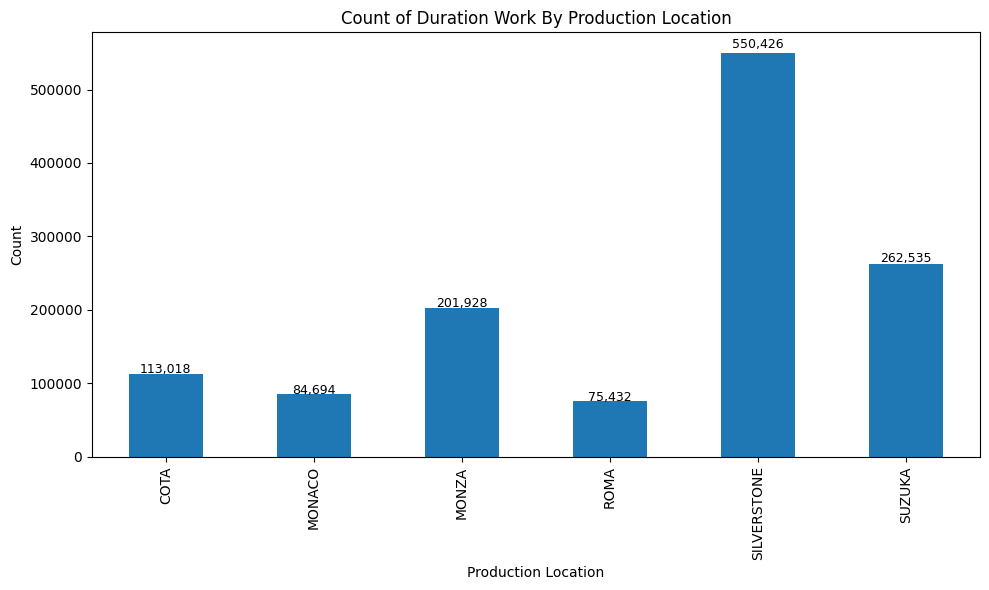

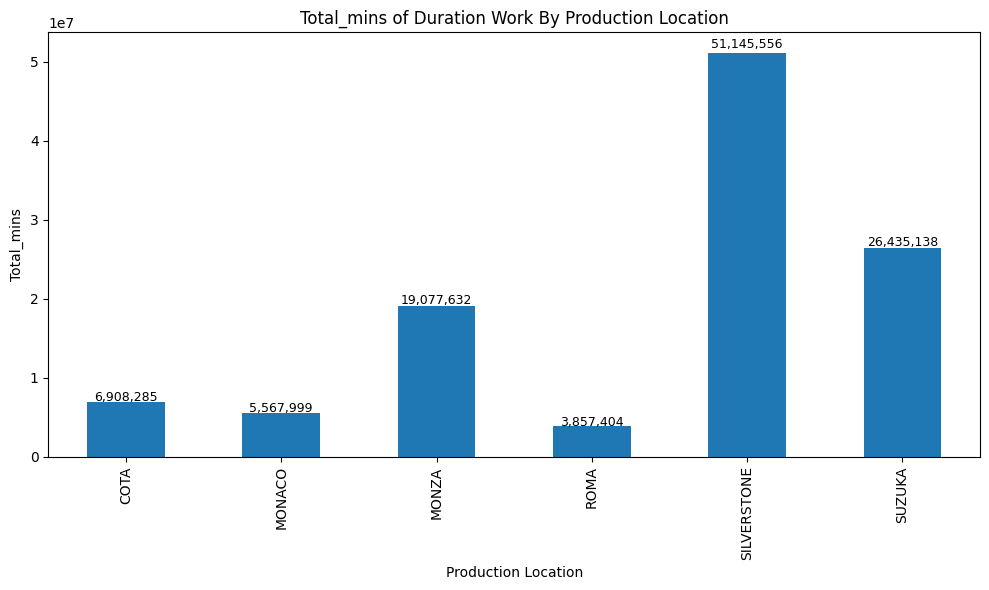

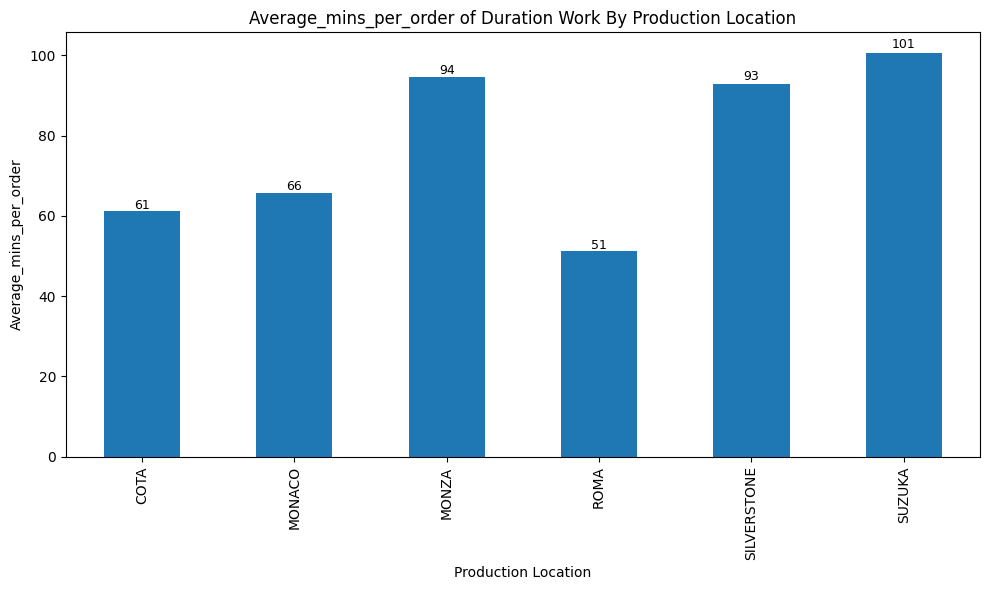

In [35]:
for column in ['count', 'total_mins', 'average_mins_per_order']:
    plt.figure(figsize=(10, 6))

    sum_minutes_by_location[column].plot(kind='bar')

    plt.title(f'{column.capitalize()} of Duration Work By Production Location')
    plt.ylabel(f'{column.capitalize()}')
    plt.xlabel('Production Location')

    for i, value in enumerate(sum_minutes_by_location[column]):
        plt.text(i, value + value * 0.01, f'{value:,.0f}', fontsize=9, ha='center')

    plt.tight_layout()

    plt.show()

These all seem to actually be in pretty uniform course with each metric, no real hints here. The average job time may be worth exploring since I would assume the jobs would take roughly the same amount of time. We can further visualize this below.

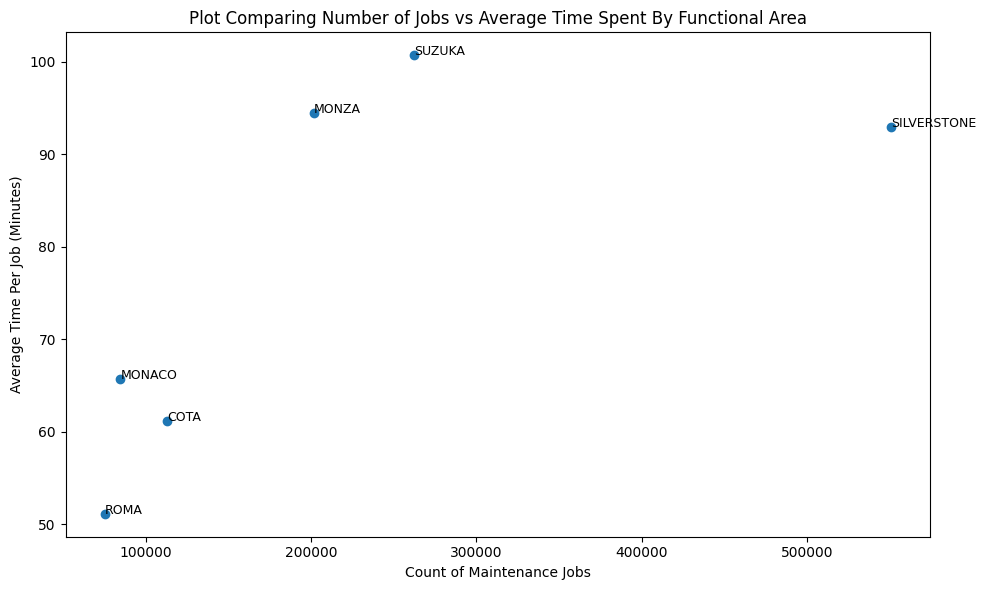

In [36]:
count_x = df_2018['PRODUCTION_LOCATION'].value_counts()
count_y = df_2018.groupby('PRODUCTION_LOCATION')['ACTUAL_WORK_IN_MINUTES'].mean()

merged_counts = pd.DataFrame({'occurences': count_x, 'average_time': count_y})

plt.figure(figsize=(10,6))
plt.scatter(merged_counts['occurences'], merged_counts['average_time'])
for i, value in merged_counts.iterrows():
    plt.text(value['occurences'], value['average_time'], str(i), fontsize=9, ha='left')
plt.xlabel('Count of Maintenance Jobs')
plt.ylabel('Average Time Per Job (Minutes)')
plt.title('Plot Comparing Number of Jobs vs Average Time Spent By Functional Area')
plt.tight_layout()
plt.show()

### Bar Plots

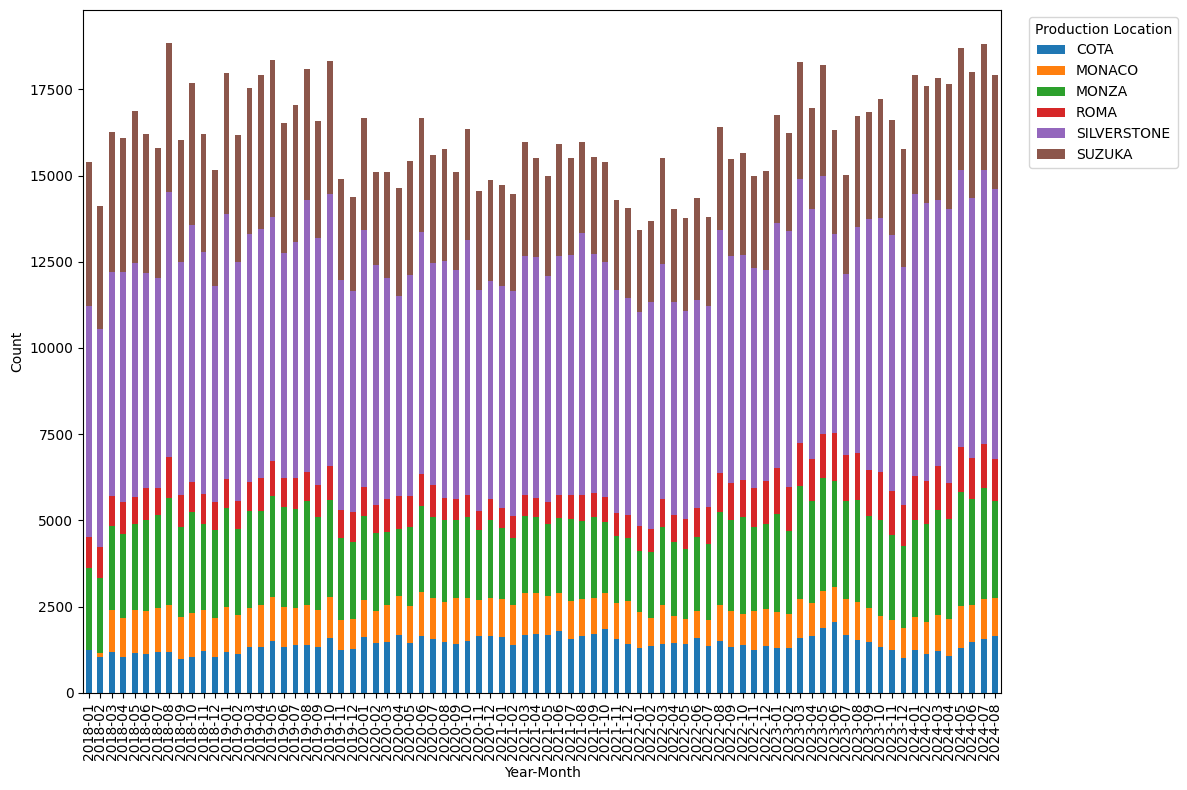

In [37]:
jobs_by_plant = df_2018.groupby(['START_YEAR_MONTH','PRODUCTION_LOCATION']).size().unstack()

jobs_by_plant.plot(kind='bar', stacked=True, figsize=(12,8))
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.legend(title='Production Location', loc='upper right', bbox_to_anchor=(1.2,1))
plt.tight_layout()
plt.show()


Not a ton of variability between each location year over year, at least from what we can see.

In [38]:
def bar_plot_counts_by_column(dataframe, column): 
    data = dataframe.groupby(['PRODUCTION_LOCATION', column]).size().unstack(fill_value=0)

    data.plot(kind='bar', stacked=True, figsize=(14, 8))

    plt.title(f'Count of {column} by Production Location')
    plt.ylabel('Count')
    plt.xlabel('Production Location')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()

    plt.show()

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_92249/1552948378.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


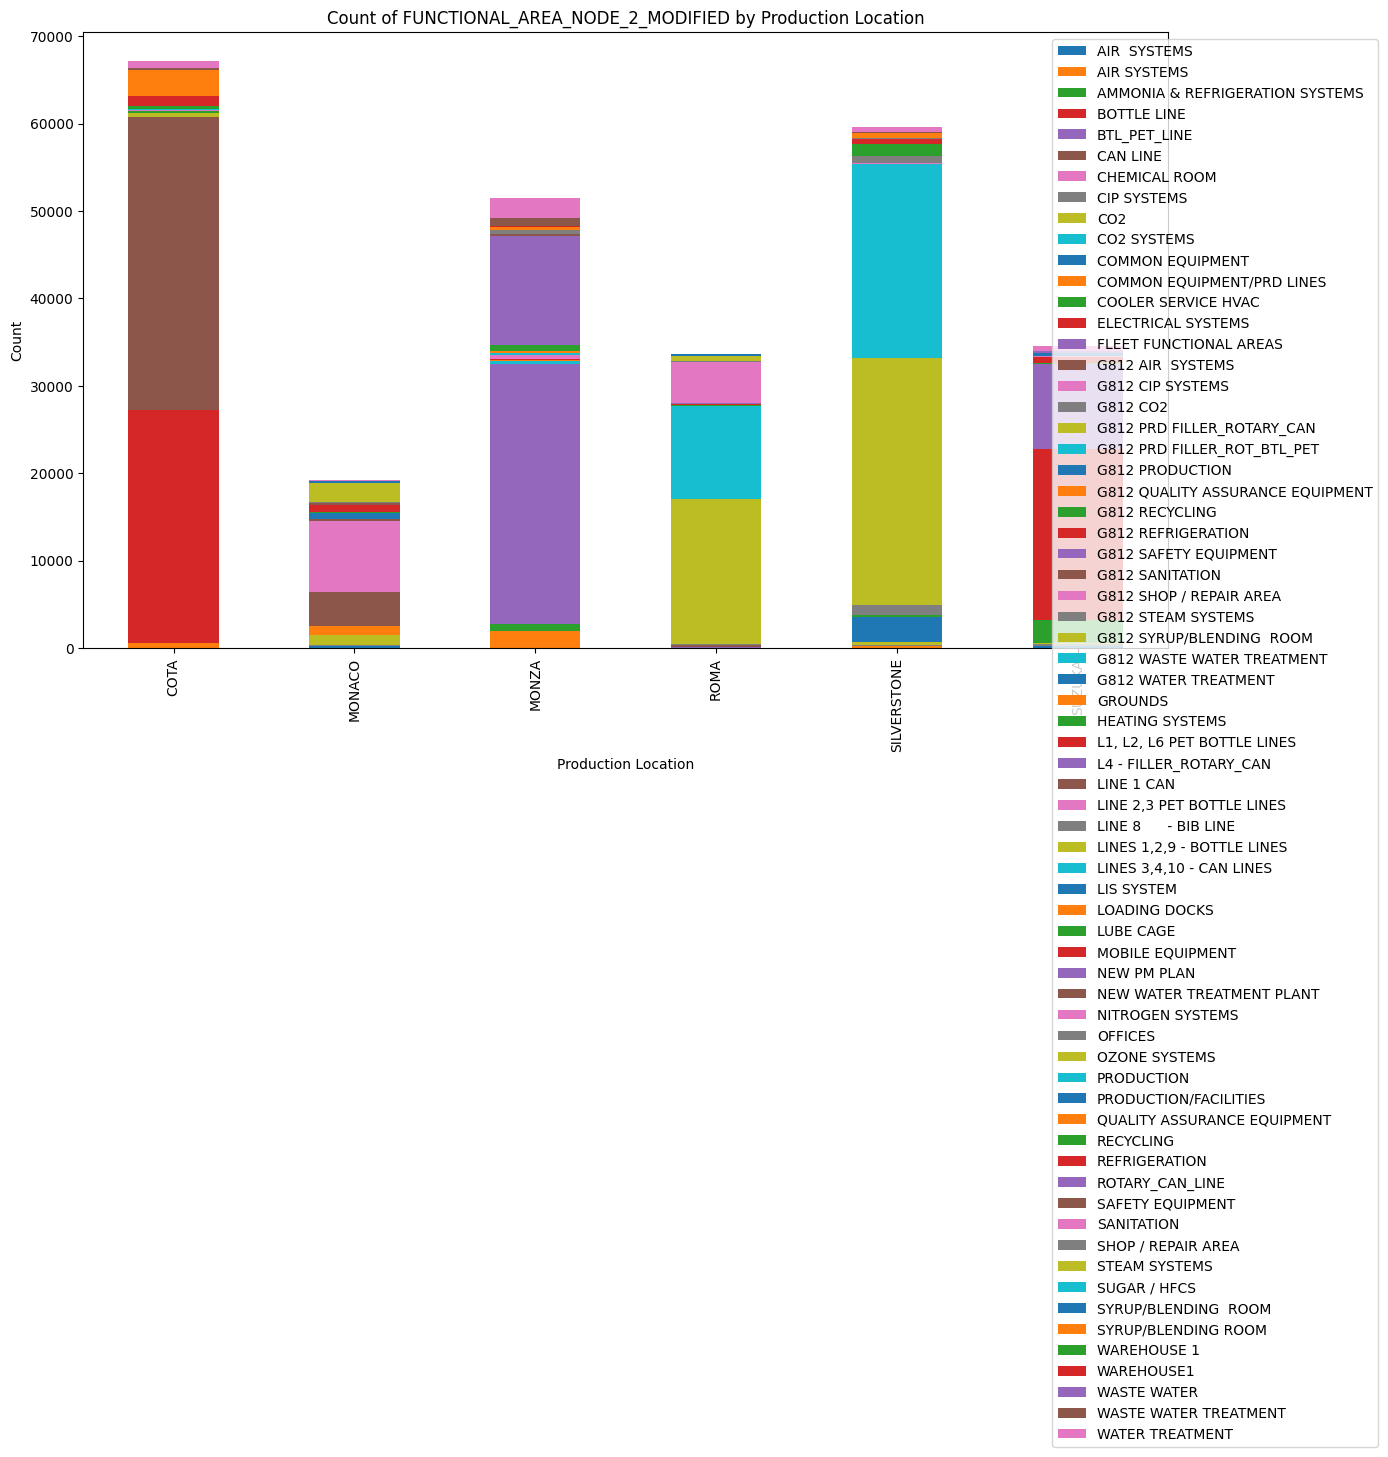

In [39]:
bar_plot_counts_by_column(df_2018, 'FUNCTIONAL_AREA_NODE_2_MODIFIED')

Well this is messy. I don't think I will continue with the other functional areas as I assume the number of unique line items will continue to grow.

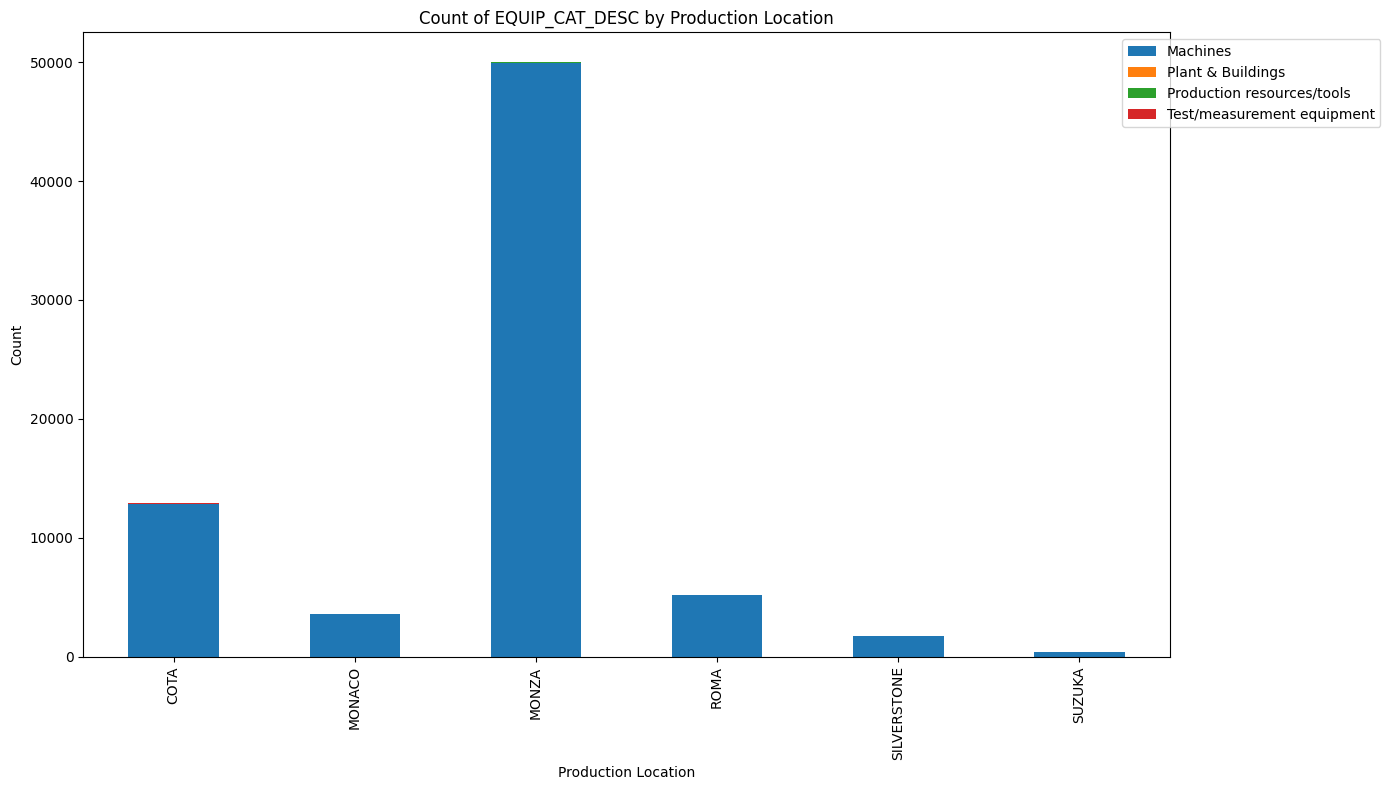

In [40]:
bar_plot_counts_by_column(df_2018, 'EQUIP_CAT_DESC')

This is telling. I wonder if there are a lot of line items that don't necessarily have to do with the machines, which leads me to believe these may not be "line critical."

In [41]:
df_2018_machines = df_2018[df_2018['EQUIP_CAT_DESC'] == 'Machines']

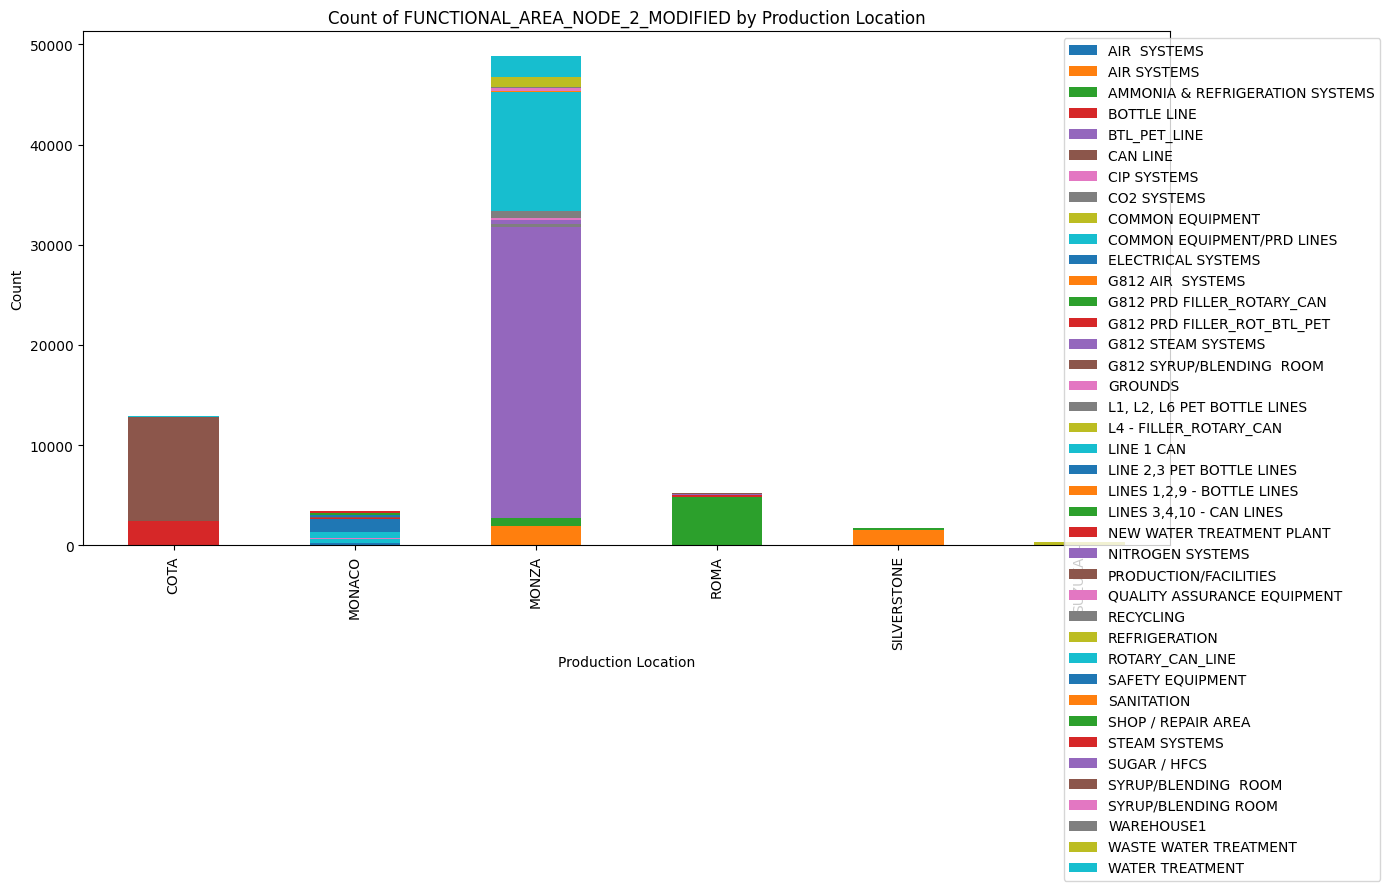

In [42]:
bar_plot_counts_by_column(df_2018_machines, 'FUNCTIONAL_AREA_NODE_2_MODIFIED')

That seemed to have shrunk the amount of equipment descriptions we have to deal with, let's be sure.

In [116]:
# before filtering to just machines
df_2018['EQUIPMENT_DESC'].nunique()


800

In [117]:
# after filtering out to machines
df_2018_machines['EQUIPMENT_DESC'].nunique()

769

Okay, so not much of a difference. Maybe there is a difference if we filter out descriptions that only occur a few times, which wouldn't be super important for keeping track of. The problem with all this is the sparsity of this dataset, which doesn't give us a good idea of "what" is being replaced since equipment_desc is 90% sparse.

### Binning
For the EQUIPMENT_IDs that we do have, I'm going to break down some stats regarding how many jobs and the average work time per part.

In [119]:
avg_work_part =  df_2018.groupby('EQUIPMENT_ID').agg(
    count=('EQUIPMENT_DESC', 'size'),
    avg_work_time=('ACTUAL_WORK_IN_MINUTES', 'mean')
).sort_values(by='count', ascending=False).reset_index()

avg_work_part

,EQUIPMENT_ID,count,avg_work_time
0,300025792.0,4494,106.790387
1,300017655.0,4016,90.468078
2,300115000.0,3745,88.618798
3,300026891.0,2965,91.093356
4,300017654.0,2890,139.134602
...,...,...,...
2936,300167400.0,1,60.000000
2937,300001323.0,1,60.000000
2938,300001322.0,1,60.000000
2939,300170601.0,1,30.000000


In [120]:
count_bins=[0,1,5,10,25,50,100,500,5000]
avg_work_part['binned'] = pd.cut(avg_work_part['count'], count_bins)

avg_work_part.head()

,EQUIPMENT_ID,count,avg_work_time,binned
0,300025792.0,4494,106.790387,"(500, 5000]"
1,300017655.0,4016,90.468078,"(500, 5000]"
2,300115000.0,3745,88.618798,"(500, 5000]"
3,300026891.0,2965,91.093356,"(500, 5000]"
4,300017654.0,2890,139.134602,"(500, 5000]"


In [121]:
avg_work_part.tail()

,EQUIPMENT_ID,count,avg_work_time,binned
2936,300167400.0,1,60.0,"(0, 1]"
2937,300001323.0,1,60.0,"(0, 1]"
2938,300001322.0,1,60.0,"(0, 1]"
2939,300170601.0,1,30.0,"(0, 1]"
2940,200087110.0,1,6.0,"(0, 1]"


In [122]:
avg_bins = avg_work_part.groupby('binned').agg(
    total_count=('count', 'sum'),
    avg_time=('avg_work_time', 'mean'),
    median_time=('avg_work_time', 'median')
)

avg_bins

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_92249/3850030528.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bins = avg_work_part.groupby('binned').agg(


,total_count,avg_time,median_time
binned,,,
"(0, 1]",429,181.320280,120.000000
"(1, 5]",2074,157.527464,105.000000
"(5, 10]",2136,149.282001,124.642857
"(10, 25]",6781,129.983198,97.071429
"(25, 50]",8357,103.859062,83.333333
"(50, 100]",22434,77.092770,67.628571
"(100, 500]",98488,81.394170,74.045000
"(500, 5000]",134130,95.602328,91.647628


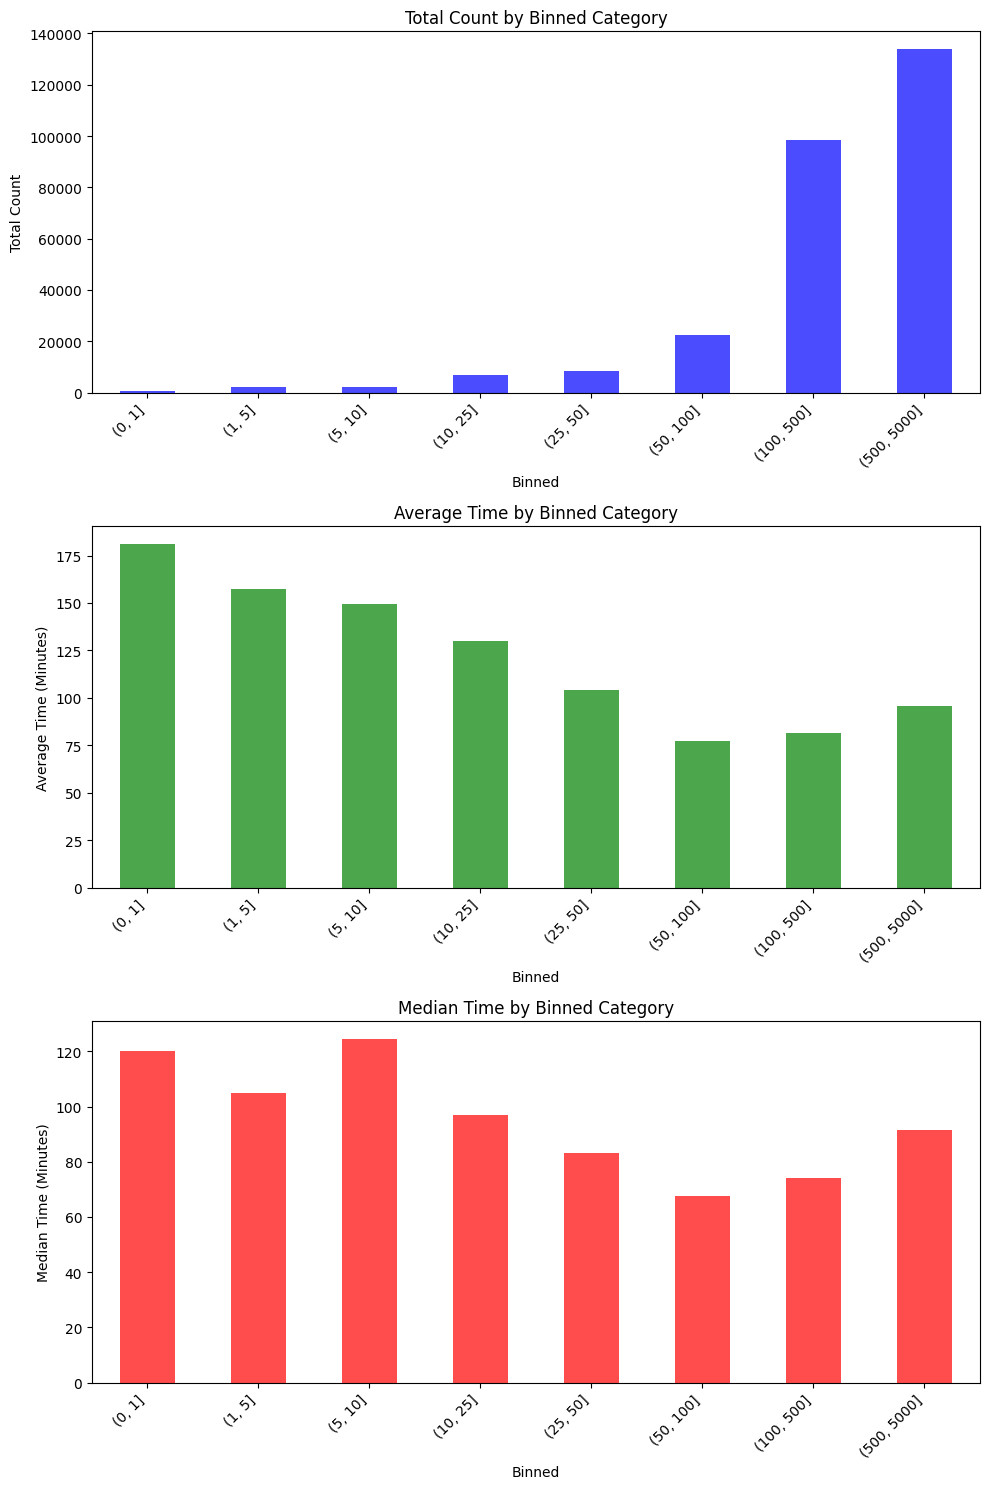

In [123]:
# Create a figure with multiple subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot 'total_count' for each 'binned' category
avg_bins['total_count'].plot(kind='bar', ax=ax[0], color='blue', alpha=0.7)
ax[0].set_title('Total Count by Binned Category')
ax[0].set_xlabel('Binned')
ax[0].set_ylabel('Total Count')
ax[0].set_xticklabels(avg_bins.index, rotation=45, ha='right')

# Plot 'avg_time' for each 'binned' category
avg_bins['avg_time'].plot(kind='bar', ax=ax[1], color='green', alpha=0.7)
ax[1].set_title('Average Time by Binned Category')
ax[1].set_xlabel('Binned')
ax[1].set_ylabel('Average Time (Minutes)')
ax[1].set_xticklabels(avg_bins.index, rotation=45, ha='right')

# Plot 'median_time' for each 'binned' category
avg_bins['median_time'].plot(kind='bar', ax=ax[2], color='red', alpha=0.7)
ax[2].set_title('Median Time by Binned Category')
ax[2].set_xlabel('Binned')
ax[2].set_ylabel('Median Time (Minutes)')
ax[2].set_xticklabels(avg_bins.index, rotation=45, ha='right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

There seems to be a trade off here. Equipment descriptions with low number of counts seems to take a bit more time, but since they only show up once, there's not much we can do to do preemptive about their maintenance since there isn't a lot to learn from. I would be tempted to make the argument that equipment descriptions that only show up less than 5 - 6 times should be taken out, since we can probably make the assumption that, given our new timeframe, these items are only maintained once a year or less.

### Time For Parts

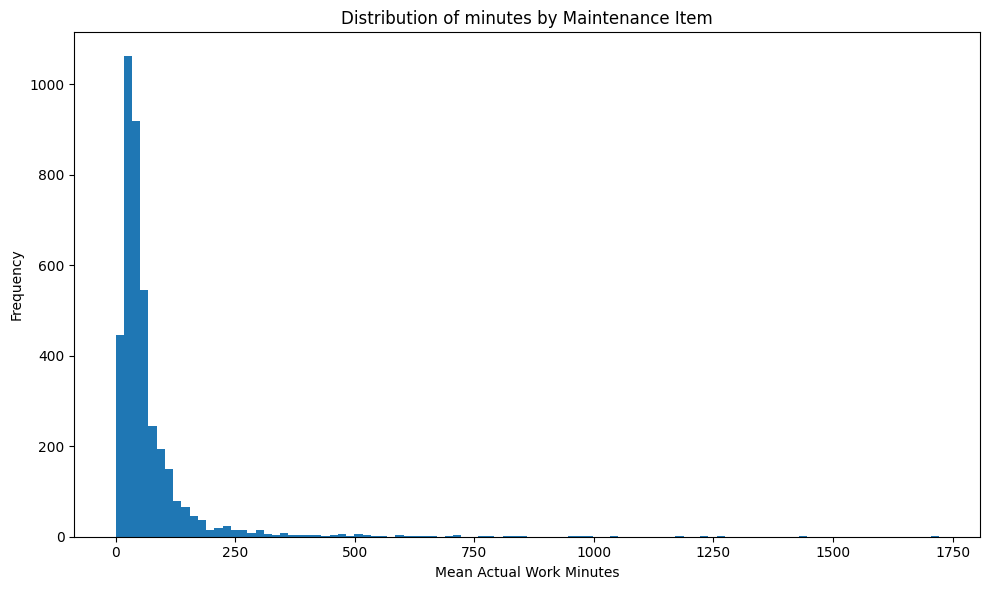

In [124]:
mean_minutes_by_maintenance_item = df_2018.groupby('MAINTENANCE_ITEM')['ACTUAL_WORK_IN_MINUTES'].mean()

plt.figure(figsize=(10,6))
plt.hist(mean_minutes_by_maintenance_item, bins=100)
plt.title("Distribution of minutes by Maintenance Item")
plt.xlabel("Mean Actual Work Minutes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Parts
Work in Progress.

In [125]:
count_by_part = df_2018.groupby(['EQUIPMENT_ID', 'EQUIPMENT_DESC']).size().reset_index()

count_by_part = count_by_part.sort_values('EQUIPMENT_DESC')

In [126]:
count_by_part.to_csv('part_list.csv')

I might manually look through these to understand what the parts look like in terms of their names. I'm guessing theres going to be a ton of overlap with small changes between parts, like L1 CONV_FC_SEAMER_DISCHARGE_FC1A vs L1 CONV_FC_SEAMER_DISCHARGE_FC1B. It's possible we could do some grouping to lower the amount of descriptions and taking out the FCxx in this case, but that might just be easiest to do manually.

Let's experiment with some counting of some of these descriptions by functional location.

In [127]:
df[df['EQUIPMENT_DESC'] == 'L1 FILLER_ROTARY_CAN_72_VALVE'].groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE']).size()

PRODUCTION_LOCATION  FUNCTIONAL_LOC         EXECUTION_START_DATE
COTA                 G816-PRD-L15-L01-L080  2019-10-06              1
                                            2019-10-07              1
                                            2019-10-11              6
                                            2019-10-12              2
                                            2019-10-13              2
                                                                   ..
                                            2024-08-25              1
                                            2024-08-26              8
                                            2024-08-27              6
                                            2024-08-28              4
                                            2024-08-29              2
Length: 1355, dtype: int64

Interestingly enough, there are multiple cases where a FUNCTIONAL_LOC has multiple work orders per day. This is not what I thought the functional location was. I figured it was the exact point at which the part was changed, but after looking over the dictionary again it seems it is more of an "area."

FUNCTIONAL_LOC seems to be a bit of a dead end however, since there is only 5% population of data in the column.

## Breaking Down By Plant

One of my goals is to find what the relationship between how much time is spent on work orders, vs what the max time spent on a work order is. This is because if we know what a max time is for a maintenance order, and it is on a line, then we should be able to fit more smaller jobs underneath that max time. 

In [137]:
jobs_by_plant = df_2018.groupby(['PRODUCTION_LOCATION', 'EXECUTION_START_DATE']).agg(
    count=('START_YEAR_MONTH', 'size'),
    total_time=('ACTUAL_WORK_IN_MINUTES', 'sum'),
    max_time=('ACTUAL_WORK_IN_MINUTES', 'max')
)

jobs_by_plant['time_delta_perc'] = jobs_by_plant['max_time']/jobs_by_plant['total_time']

jobs_by_plant.head()

count  total_time  max_time  \
PRODUCTION_LOCATION EXECUTION_START_DATE                                
COTA                2018-01-01                1         0.0       0.0   
                    2018-01-02               17      2148.0     720.0   
                    2018-01-03               53      2349.0     360.0   
                    2018-01-04               49      1917.0     240.0   
                    2018-01-05               47      2361.0     390.0   

                                          time_delta_perc  
PRODUCTION_LOCATION EXECUTION_START_DATE                   
COTA                2018-01-01                        NaN  
                    2018-01-02                   0.335196  
                    2018-01-03                   0.153257  
                    2018-01-04                   0.125196  
                    2018-01-05                   0.165184

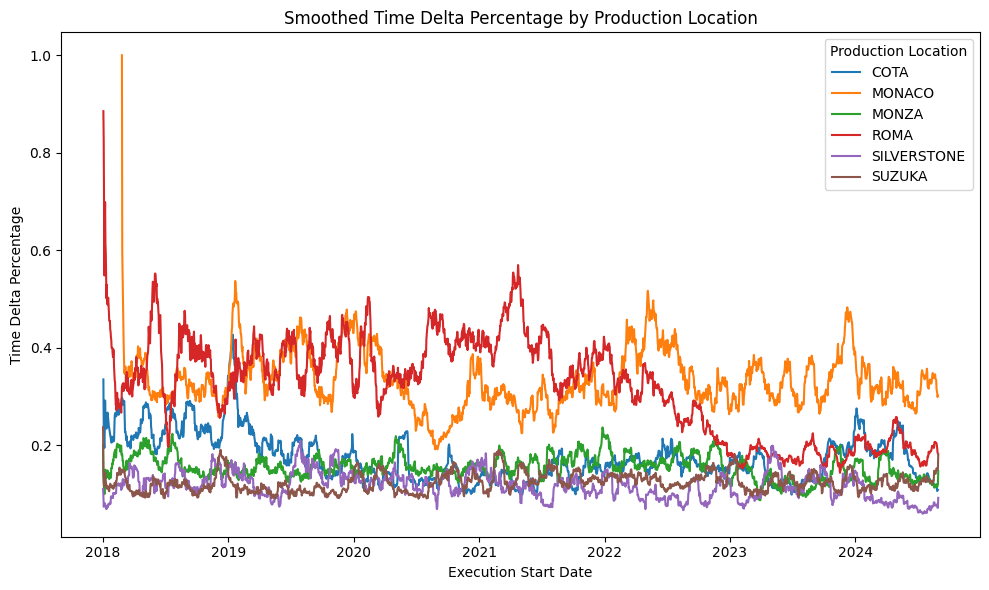

In [138]:
production_locations = jobs_by_plant.index.get_level_values('PRODUCTION_LOCATION').unique()

# Create a single figure and axis for one combined plot
fig, ax = plt.subplots(figsize=(10, 6))

# One month window for rolling average
window_size = 30

# Plot each production location on the same plot
for location in production_locations:
    # Filter data for the specific production location
    location_data = jobs_by_plant.xs(location, level='PRODUCTION_LOCATION')

    # Calculate rolling average
    smoothed_time_delta_perc = location_data['time_delta_perc'].rolling(window=window_size, min_periods=1).mean()

    # Plot each location's data on the same axis
    ax.plot(location_data.index, smoothed_time_delta_perc, label=location)

# Set title and labels
ax.set_title('Smoothed Time Delta Percentage by Production Location')
ax.set_xlabel('Execution Start Date')
ax.set_ylabel('Time Delta Percentage')

# Add legend to distinguish production locations
ax.legend(title='Production Location')

# Show the plot
plt.tight_layout()
plt.show()


This shows the relationship between how long a max job took vs the total length of jobs that day. I used a 30 day rolling average, which represents a month. If the trend is low, I would make the assumption that there is more room to create more jobs underneath that job.

## Naming Conventions

This section is currently a work in progress.

In [56]:
import re

df['EQUIPMENT_DESC'] = df['EQUIPMENT_DESC'].astype(str)

# Define a function to strip numbers and anything between parentheses
def strip_numbers_and_parentheses(equipment_desc):
    # Remove anything in parentheses
    equipment_desc = re.sub(r'\(.*?\)', '', equipment_desc)
    # Remove numbers
    equipment_desc = re.sub(r'\d+', '', equipment_desc)

    equipment_desc = equipment_desc.replace('_', '')
    # Remove extra whitespace that may result from stripping
    equipment_desc = equipment_desc.strip()
    return equipment_desc

# Apply the function to strip numbers and parentheses
df['CLEANED_EQUIPMENT_DESC'] = df['EQUIPMENT_DESC'].apply(strip_numbers_and_parentheses)

In [57]:
df.groupby(['EQUIPMENT_DESC', 'CLEANED_EQUIPMENT_DESC']).size().sort_values()


EQUIPMENT_DESC                  CLEANED_EQUIPMENT_DESC  
L10 WATER HEATER-ARMSTRONG      L WATER HEATER-ARMSTRONG          1
FULL CAN CONVEYOR (FC50)        FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC49)        FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC45D)       FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC45C)       FULL CAN CONVEYOR                 1
                                                             ...   
L2 FILLER_ROTARY_BTL_45_VALVE   L FILLERROTARYBTLVALVE         2072
L4 FILLER_ROTARY_CAN_100_VALVE  L FILLERROTARYCANVALVE         2511
L1 FILLER_ROTARY_BTL_60_VALVE   L FILLERROTARYBTLVALVE         2738
L1 FILLER_ROTARY_CAN_72_VALVE   L FILLERROTARYCANVALVE         3745
nan                             nan                         1347817
Length: 808, dtype: int64

In [58]:
df.groupby('CLEANED_EQUIPMENT_DESC').size().sort_values(ascending=False)

CLEANED_EQUIPMENT_DESC
nan                                1347817
L FILLERROTARYCANVALVE                7010
L FILLERROTARYBTLVALVE                6284
L LABELERROTARY                       2583
L PACKRCASEWESTROCKDDM                2093
                                    ...   
PUMPCENTSANITFILLERRETURN L              1
PUMPCENTSANITDISCHARGE L                 1
PUMPCENTSANITBLENDTANK L                 1
PUMPCENTSANIT                            1
L DOMINO LASER CAN CODER - EAST          1
Length: 569, dtype: int64

In [59]:
#### ADD IN filter for just equipment with descriptions

In [60]:
# Group by PLANT_ID, FUNCTIONAL_AREA_NODE_3_MODIFIED, and EQUIPMENT_ID
grouped_df = df.groupby(['PLANT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'EQUIPMENT_ID'])

# Calculate the time difference between the earliest EXECUTION_START_DATE and the latest EXECUTION_FINISH_DATE for each group
df['TIME_BETWEEN_START_AND_FINISH'] = (df['EXECUTION_FINISH_DATE'] - df['EXECUTION_START_DATE']).dt.days

# For each group, find the time span between the first execution start date and the last execution finish date
time_span_by_group = grouped_df.agg(
    FIRST_EXECUTION_START=pd.NamedAgg(column='EXECUTION_START_DATE', aggfunc='min'),
    LAST_EXECUTION_FINISH=pd.NamedAgg(column='EXECUTION_FINISH_DATE', aggfunc='max')
)

# Calculate the duration (in days) between the first execution start and the last execution finish
time_span_by_group['TIME_SPAN_IN_DAYS'] = (time_span_by_group['LAST_EXECUTION_FINISH'] - time_span_by_group['FIRST_EXECUTION_START']).dt.days

# Reset the index for easier reading
time_span_by_group = time_span_by_group.reset_index()


In [61]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,START_YEAR_MONTH,YEAR,CLEANED_EQUIPMENT_DESC,TIME_BETWEEN_START_AND_FINISH
0,705642457,G812,ROMA,2024-05-04,2024-05-12,1900-01-01 06:00:00,1900-01-01 23:04:08,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2024-05,2024,FULL CAN CONVEYOR,8
1,704191697,G812,ROMA,2022-09-13,2022-09-13,1900-01-01 06:00:00,1900-01-01 17:17:24,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-09,2022,FULL CAN CONVEYOR,0
2,704466547,G812,ROMA,2022-12-21,2022-12-21,1900-01-01 07:00:00,1900-01-01 07:00:00,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-12,2022,FULL CAN CONVEYOR,0
3,703834477,G812,ROMA,2022-07-04,2022-07-04,1900-01-01 06:00:00,1900-01-01 06:00:00,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-07,2022,FULL CAN CONVEYOR,0
4,704661125,G291,MONZA,2023-03-15,2023-03-15,1900-01-01 07:00:00,1900-01-01 07:00:00,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,NaT,2023-03,2023,TANKSTLSTORAIR,0


In [62]:
example_time_diff = df[df['FUNCTIONAL_LOC'] == 'G812-PRD-L15-L03-L030-020'].sort_values('EXECUTION_START_DATE')

In [63]:
selected_columns = ['ORDER_ID', 'PLANT_ID', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIPMENT_ID', 'EQUIPMENT_DESC', 'TIME_BETWEEN_START_AND_FINISH']
filtered_selected_df = example_time_diff[selected_columns]

In [64]:
filtered_selected_df.head()

,ORDER_ID,PLANT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,EQUIPMENT_ID,EQUIPMENT_DESC,TIME_BETWEEN_START_AND_FINISH
229859,702712501,G812,G812-PRD-L15-L03-L030-020,2021-01-16,2021-01-16,300126836.0,FULL CAN CONVEYOR (FC60),0
1065751,702711538,G812,G812-PRD-L15-L03-L030-020,2021-01-16,2021-01-16,300126811.0,FULL CAN CONVEYOR (FC41A),0
1383307,702764911,G812,G812-PRD-L15-L03-L030-020,2021-02-10,2021-02-10,300126814.0,FULL CAN CONVEYOR (FC43),0
1065754,703036469,G812,G812-PRD-L15-L03-L030-020,2021-06-24,2021-06-24,300126811.0,FULL CAN CONVEYOR (FC41A),0
1065748,703141582,G812,G812-PRD-L15-L03-L030-020,2021-11-23,2022-01-18,300126811.0,FULL CAN CONVEYOR (FC41A),56


## Finding Lifespans

My idea of a model is that, if we can find trends in the time between breakdowns for the parts, we will be able to create points in time where we can expect large amoutns of maintenance. If we can line these points up, we can minimize line downtime since the line will only go down once, vs many times.

I will try to describe this below.

### By Production Location and Equipment ID

#### Filtering
The first step is to boil the dataset down to columns that are needed.

In [153]:
selected_columns = ['PRODUCTION_LOCATION', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']

sm_df_2018 = df_2018[selected_columns].sort_values(selected_columns)

sm_df_2018.head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES
224341,COTA,200087110.0,2021-03-30,2021-03-30,6.0
85758,COTA,300025746.0,2018-05-23,2018-05-23,6.0
1105210,COTA,300025746.0,2019-10-22,2019-10-22,30.0
400803,COTA,300025746.0,2021-08-26,2021-08-26,6.0
1374735,COTA,300025746.0,2023-12-08,2023-12-08,19.2


Now, I want to filter out anything that has a count of 1 or below since these dont offer much to learn from.

In [154]:
# filter rows with count of only 1, this should also take out null values
sm_df_2018_filtered = sm_df_2018.groupby('EQUIPMENT_ID').filter(lambda x: len(x) > 1)[selected_columns]

sm_df_2018_filtered.head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES
85758,COTA,300025746.0,2018-05-23,2018-05-23,6.0
1105210,COTA,300025746.0,2019-10-22,2019-10-22,30.0
400803,COTA,300025746.0,2021-08-26,2021-08-26,6.0
1374735,COTA,300025746.0,2023-12-08,2023-12-08,19.2
843279,COTA,300025747.0,2018-05-23,2018-05-23,6.0


In [155]:
# how many lines were taken out
len(sm_df_2018) - len(sm_df_2018_filtered)

1013633

#### Aggregate
Now we can find how many times a product was maintained by day, and how much time it took.

In [157]:
sm_df_2018_filtered_agg = sm_df_2018_filtered.groupby(['PRODUCTION_LOCATION','EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE',]).agg(
    counts=('EQUIPMENT_ID', 'size'),
    total_mins=('ACTUAL_WORK_IN_MINUTES', 'sum')
).reset_index()

sm_df_2018_filtered_agg

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,counts,total_mins
0,COTA,300025746.0,2018-05-23,2018-05-23,1,6.0
1,COTA,300025746.0,2019-10-22,2019-10-22,1,30.0
2,COTA,300025746.0,2021-08-26,2021-08-26,1,6.0
3,COTA,300025746.0,2023-12-08,2023-12-08,1,19.2
4,COTA,300025747.0,2018-05-23,2018-05-23,1,6.0
...,...,...,...,...,...,...
206294,SUZUKA,400028001.0,2023-09-21,2023-09-21,1,240.0
206295,SUZUKA,400028001.0,2023-12-06,2023-12-06,1,240.0
206296,SUZUKA,400028001.0,2023-12-16,2023-12-16,1,240.0
206297,SUZUKA,400028001.0,2023-12-19,2023-12-19,1,240.0


#### Find Last Execution
We want to find the last maintenance date so we can find the average between these times.

In [158]:
# Group by PLANT_ID and EQUIPMENT_ID
sm_df_2018_filtered_agg['PREV_EXECUTION_FINISH_DATE'] = sm_df_2018_filtered_agg.groupby(['PRODUCTION_LOCATION', 'EQUIPMENT_ID'])['EXECUTION_FINISH_DATE'].shift(1)

sm_df_2018_filtered_agg.head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,counts,total_mins,PREV_EXECUTION_FINISH_DATE
0,COTA,300025746.0,2018-05-23,2018-05-23,1,6.0,NaT
1,COTA,300025746.0,2019-10-22,2019-10-22,1,30.0,2018-05-23
2,COTA,300025746.0,2021-08-26,2021-08-26,1,6.0,2019-10-22
3,COTA,300025746.0,2023-12-08,2023-12-08,1,19.2,2021-08-26
4,COTA,300025747.0,2018-05-23,2018-05-23,1,6.0,NaT


#### Find Lifespan
LIFE represents the time between the maintenance by location and equipment_id.

In [159]:
sm_df_2018_filtered_agg['PREV_EXECUTION_FINISH_DATE'] = sm_df_2018_filtered_agg['PREV_EXECUTION_FINISH_DATE'].fillna(sm_df_2018_filtered_agg['EXECUTION_START_DATE'])

# Calculate the time difference (life) in days between consecutive EXECUTION_START_DATE and the previous EXECUTION_FINISH_DATE
sm_df_2018_filtered_agg['LIFE'] = (sm_df_2018_filtered_agg['EXECUTION_START_DATE'] - sm_df_2018_filtered_agg['PREV_EXECUTION_FINISH_DATE']).dt.days

# Replace NaN with 0 for the first occurrence
sm_df_2018_filtered_agg['LIFE'] = sm_df_2018_filtered_agg['LIFE'].fillna(pd.NA)

sm_df_2018_filtered_agg.head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,counts,total_mins,PREV_EXECUTION_FINISH_DATE,LIFE
0,COTA,300025746.0,2018-05-23,2018-05-23,1,6.0,2018-05-23,0
1,COTA,300025746.0,2019-10-22,2019-10-22,1,30.0,2018-05-23,517
2,COTA,300025746.0,2021-08-26,2021-08-26,1,6.0,2019-10-22,674
3,COTA,300025746.0,2023-12-08,2023-12-08,1,19.2,2021-08-26,834
4,COTA,300025747.0,2018-05-23,2018-05-23,1,6.0,2018-05-23,0


Looks like there are times where the same equipment_id is worked on in a day, so this should be accounted for.

In [160]:
sm_df_2018_filtered_agg[sm_df_2018_filtered_agg['counts'] > 1].head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,counts,total_mins,PREV_EXECUTION_FINISH_DATE,LIFE
32,COTA,300025754.0,2018-02-01,2018-02-02,2,48.0,2018-01-17,15
34,COTA,300025754.0,2018-08-30,2018-08-30,2,48.0,2018-05-17,105
36,COTA,300025754.0,2018-11-20,2018-11-20,4,42.0,2018-10-06,45
37,COTA,300025754.0,2018-12-07,2018-12-07,2,48.0,2018-11-20,17
41,COTA,300025754.0,2019-02-25,2019-02-25,2,78.0,2019-02-20,5


In [161]:
# simpler naming
workable_df = sm_df_2018_filtered_agg

In [162]:
weighted_life = workable_df.groupby(['PRODUCTION_LOCATION', 'EQUIPMENT_ID']).apply(
    lambda x: pd.Series({
        # adding a weight to the counts
        'WEIGHTED_MEAN_LIFESPAN': (x['LIFE'] * x['counts']).sum() / x['counts'].sum(),
        'MEAN_TIME_MAINTENENCE': x['total_mins'].mean()
    })
).reset_index()

weighted_life.head()

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_92249/2873570169.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_life = workable_df.groupby(['PRODUCTION_LOCATION', 'EQUIPMENT_ID']).apply(


,PRODUCTION_LOCATION,EQUIPMENT_ID,WEIGHTED_MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE
0,COTA,300025746.0,506.25,15.3
1,COTA,300025747.0,587.50,6.0
2,COTA,300025748.0,587.50,9.0
3,COTA,300025749.0,587.50,6.0
4,COTA,300025750.0,125.40,46.8


In [163]:
len(weighted_life)

2512

Now we want to map these values back to the other data frame.

In [164]:
selected_columns = ['PRODUCTION_LOCATION', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES', 'PREV_EXECUTION_FINISH_DATE', 'LIFE', 'MEAN_LIFESPAN', 'MEAN_TIME_MAINTENENCE']

df_2018_filtered = df_2018[df_2018['EQUIPMENT_ID'].notna()].filter(selected_columns)

len(df_2018_filtered)

274829

In [165]:
df_2018_filtered.sort_values(['PRODUCTION_LOCATION', 'EQUIPMENT_ID', 'EXECUTION_START_DATE'])

df_lifespan = pd.merge(df_2018_filtered, weighted_life, on=['PRODUCTION_LOCATION', 'EQUIPMENT_ID'], how='left')

df_lifespan.head()

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,WEIGHTED_MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE
0,ROMA,300126812.0,2024-05-04,2024-05-12,390.0,167.500000,225.0
1,ROMA,300126812.0,2022-09-13,2022-09-13,420.0,167.500000,225.0
2,ROMA,300126812.0,2022-12-21,2022-12-21,30.0,167.500000,225.0
3,ROMA,300126812.0,2022-07-04,2022-07-04,60.0,167.500000,225.0
4,MONZA,300001088.0,2023-03-15,2023-03-15,120.0,487.666667,206.0


In [166]:
len(df_lifespan)

274829

This is the same length as our dataframe without the weighted mean lifespan, which tells me our join was good.

In [167]:
df_lifespan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274829 entries, 0 to 274828
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PRODUCTION_LOCATION     274829 non-null  object        
 1   EQUIPMENT_ID            274829 non-null  float64       
 2   EXECUTION_START_DATE    274829 non-null  datetime64[ns]
 3   EXECUTION_FINISH_DATE   274829 non-null  datetime64[ns]
 4   ACTUAL_WORK_IN_MINUTES  274829 non-null  float64       
 5   WEIGHTED_MEAN_LIFESPAN  274400 non-null  float64       
 6   MEAN_TIME_MAINTENENCE   274400 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 14.7+ MB


Now find difference between actual work periods and what was calculated.

In [169]:
# Add WEIGHTED_MEAN_LIFESPAN as a timedelta to EXECUTION_FINISH_DATE
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = df_lifespan['EXECUTION_FINISH_DATE'] + pd.to_timedelta(df_lifespan['WEIGHTED_MEAN_LIFESPAN'], unit='D')

# Ensure the EXPECTED_MAINTENANCE_DATE is in datetime format
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = pd.to_datetime(df_lifespan['EXPECTED_MAINTENANCE_DATE'])

# finds the date in which the next maintenance actually happened
df_lifespan['ACTUAL_NEXT_MAINTENACE'] = pd.to_datetime(df_lifespan.groupby(['PRODUCTION_LOCATION', 'EQUIPMENT_ID'])['EXECUTION_START_DATE'].shift(-1))

# creates a difference between our expected and actual dates
df_lifespan['EXPECTED_DIFFERENCE'] = (df_lifespan['EXPECTED_MAINTENANCE_DATE'] - df_lifespan['ACTUAL_NEXT_MAINTENACE']).dt.days

# Calculate the difference between EXPECTED_MAINTENANCE_DATE and ACTUAL_NEXT_MAINTENACE in days
df_lifespan['EXPECTED_DIFFERENCE'] = (df_lifespan['EXPECTED_MAINTENANCE_DATE'] - df_lifespan['ACTUAL_NEXT_MAINTENACE']).dt.days


In [170]:
# Display the first few rows
df_lifespan.head(20)

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,WEIGHTED_MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE,EXPECTED_MAINTENANCE_DATE,ACTUAL_NEXT_MAINTENACE,EXPECTED_DIFFERENCE
0,ROMA,300126812.0,2024-05-04,2024-05-12,390.0,167.500000,225.000000,2024-10-26 12:00:00.000000000,2022-09-13,774.0
1,ROMA,300126812.0,2022-09-13,2022-09-13,420.0,167.500000,225.000000,2023-02-27 12:00:00.000000000,2022-12-21,68.0
2,ROMA,300126812.0,2022-12-21,2022-12-21,30.0,167.500000,225.000000,2023-06-06 12:00:00.000000000,2022-07-04,337.0
3,ROMA,300126812.0,2022-07-04,2022-07-04,60.0,167.500000,225.000000,2022-12-18 12:00:00.000000000,NaT,NaN
4,MONZA,300001088.0,2023-03-15,2023-03-15,120.0,487.666667,206.000000,2024-07-14 16:00:00.000000002,2023-09-08,310.0
5,MONZA,300001088.0,2023-09-08,2023-09-08,18.0,487.666667,206.000000,2025-01-07 16:00:00.000000002,2019-09-06,1950.0
6,MONZA,300001088.0,2019-09-06,2019-09-06,480.0,487.666667,206.000000,2021-01-05 16:00:00.000000002,NaT,NaN
7,MONZA,300001033.0,2023-10-09,2023-10-09,30.0,30.390625,34.453125,2023-11-08 09:22:30.000000000,2023-05-01,191.0
8,MONZA,300001033.0,2023-05-01,2023-05-01,30.0,30.390625,34.453125,2023-05-31 09:22:30.000000000,2022-12-13,169.0
9,MONZA,300001033.0,2022-12-13,2022-12-13,30.0,30.390625,34.453125,2023-01-12 09:22:30.000000000,2023-03-29,-76.0


In [171]:
df_lifespan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274829 entries, 0 to 274828
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   PRODUCTION_LOCATION        274829 non-null  object        
 1   EQUIPMENT_ID               274829 non-null  float64       
 2   EXECUTION_START_DATE       274829 non-null  datetime64[ns]
 3   EXECUTION_FINISH_DATE      274829 non-null  datetime64[ns]
 4   ACTUAL_WORK_IN_MINUTES     274829 non-null  float64       
 5   WEIGHTED_MEAN_LIFESPAN     274400 non-null  float64       
 6   MEAN_TIME_MAINTENENCE      274400 non-null  float64       
 7   EXPECTED_MAINTENANCE_DATE  274400 non-null  datetime64[ns]
 8   ACTUAL_NEXT_MAINTENACE     271888 non-null  datetime64[ns]
 9   EXPECTED_DIFFERENCE        271888 non-null  float64       
dtypes: datetime64[ns](4), float64(5), object(1)
memory usage: 21.0+ MB


We can do a quick calculation of how far off our assumptions are.

In [172]:
float(df_lifespan['EXPECTED_DIFFERENCE'].mean())

13.531696875183899

## Preliminary Findings

1. Dataset Overview:
- The dataset is incredibly sparse, at only 55% filled. Some columns, that are arguably important for what I would like to do with this data, like EQUIPMENT_ID, EQUIPMENT_DESC, and Functional Locations, are increadibly sparse with 20% or under.
2. Key Variables:
- ACTUAL_WORK_IN_MINUTES: This is likely a key variable that we will want to minimize, since time is essentially our currency.
- PRODUCTION_LOCATION: Each location needs to be treated by group, since we don't want to make the mistake of measuring time between jobs for something between two plants.
- MAINTENANCE_ACTIVITY_TYPE: Categorizes the type of maintenance performed, which could be critical for optimizing scheduling.
- EQUIPMENT_ID: What is being maintained.
3. Missing Data:
- Certain columns, like MAINTENANCE_PLAN and EQUIPMENT_ID, contain many missing values (with significantly fewer non-null values compared to the total dataset).
4. Next Steps:
- Further cleaning or imputation may be required to handle missing values in MAINTENANCE_PLAN and EQUIPMENT_ID.
- Visualizations of the time spent on different maintenance activities across production locations can provide insights for optimization.
- Creating survivorship model.